<a href="https://colab.research.google.com/github/nanaessandoh/Improving-Performance-of-CNN-using-Transfer-Learning/blob/master/Experiment%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare the DataSet

In [ ]:
# Colab Notebooks come along with a folder sample_data that we dont need so we go ahead to delete it
!rm -rf /content/sample_data

In [ ]:
# Clone Repository with the Dataset
!git clone https://github.com/nanaessandoh/Pet_Images.git


Cloning into 'Pet_Images'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 7452 (delta 0), reused 82 (delta 0), pack-reused 7370
Receiving objects: 100% (7452/7452), 753.93 MiB | 38.88 MiB/s, done.
Checking out files: 100% (7418/7418), done.


In [ ]:
# Declare Path to Dataset
input_path = 'Pet_Images/'

# **Part 3 :** Freeze Layers of ResNet-152 and Train on Oxford-III Pets.

## Import Dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [ ]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

## Create Data Generators

In [ ]:
normalize = transforms.Normalize( mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.244, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

In [ ]:
image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'Train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'Validation', data_transforms['validation'])
}

In [ ]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=4), 
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=4)
}

## Create the Network

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [ ]:
model = models.resnet152(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

## Train the Model

In [ ]:
def train_model(model, criterion, optimizer, num_epochs = 10):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [ ]:
model_trained = train_model(model, criterion, optimizer, num_epochs = 10)

Epoch 1/10
----------
train loss: 0.0962, acc: 0.9692
validation loss: 0.0205, acc: 0.9910
Epoch 2/10
----------
train loss: 0.0764, acc: 0.9752
validation loss: 0.0197, acc: 0.9937
Epoch 3/10
----------
train loss: 0.0293, acc: 0.9902
validation loss: 0.0200, acc: 0.9919
Epoch 4/10
----------
train loss: 0.0461, acc: 0.9838
validation loss: 0.0308, acc: 0.9883
Epoch 5/10
----------
train loss: 0.0308, acc: 0.9897
validation loss: 0.0186, acc: 0.9919
Epoch 6/10
----------
train loss: 0.0422, acc: 0.9868
validation loss: 0.0195, acc: 0.9928
Epoch 7/10
----------
train loss: 0.0256, acc: 0.9906
validation loss: 0.0151, acc: 0.9928
Epoch 8/10
----------
train loss: 0.0311, acc: 0.9886
validation loss: 0.0189, acc: 0.9910
Epoch 9/10
----------
train loss: 0.0329, acc: 0.9881
validation loss: 0.0171, acc: 0.9919
Epoch 10/10
----------
train loss: 0.0230, acc: 0.9921
validation loss: 0.0204, acc: 0.9901


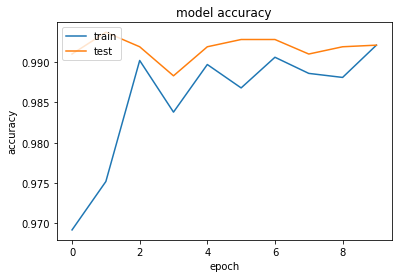

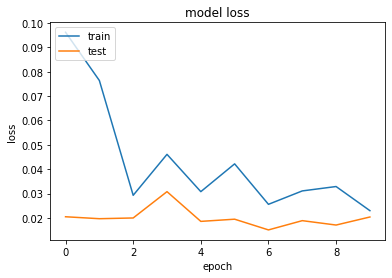

In [ ]:
import matplotlib.pyplot as plt
plt.plot([0.9692,0.9752,0.9902,0.9838,0.9897,0.9868,0.9906,0.9886,0.9881,0.9921])
plt.plot([0.9910,0.9937,0.9919,0.9883,0.9919,0.9928,0.9928,0.9910,0.9919,0.9921])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot([0.0962,0.0764,0.0293,0.0461,0.0308,0.0422,0.0256,0.0311,0.0329,0.0230])
plt.plot([0.0205,0.0197,0.0200,0.0308,0.0186,0.0195,0.0151,0.0189,0.0171,0.0204])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Make Prediction on Sample Test Images

In [ ]:
# Download Dog/Cat images from the web 
!wget -N https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/Chihuahua_01_K.jpg/640px-Chihuahua_01_K.jpg -P Dataset/Validation
!wget -N https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/American_Shorthair.jpg/360px-American_Shorthair.jpg -P Dataset/Validation
!wget -N https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/CPRileySnow.jpg/640px-CPRileySnow.jpg -P Dataset/Validation
!wget -N https://upload.wikimedia.org/wikipedia/commons/3/3d/LakiJustbluein.jpg -P Dataset/Validation
!wget -N https://upload.wikimedia.org/wikipedia/commons/thumb/0/03/Kufa_charta_-_borzoja.jpg/640px-Kufa_charta_-_borzoja.jpg -P Dataset/Validation
!wget -N https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Savannah_Cat_closeup.jpg/640px-Savannah_Cat_closeup.jpg-P Dataset/Validation

In [ ]:
validation_img_paths = ["/content/Dataset/Validation/360px-American_Shorthair.jpg",
                        "/content/Dataset/Validation/640px-CPRileySnow.jpg",
                        "/content/Dataset/Validation/640px-Chihuahua_01_K.jpg",
                        "/content/Dataset/Validation/640px-Kufa_charta_-_borzoja.jpg",
                        "/content/Dataset/Validation/LakiJustbluein.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [ ]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [ ]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[  7.1777,  -6.9060],
        [ -9.0598,   7.8547],
        [ -5.0206,   8.1731],
        [-10.2568,   8.7861],
        [  7.5607,  -7.4616]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[9.9999928e-01, 7.6471554e-07],
       [4.5094783e-08, 1.0000000e+00],
       [1.8622668e-06, 9.9999809e-01],
       [5.3675087e-09, 1.0000000e+00],
       [9.9999964e-01, 2.9913761e-07]], dtype=float32)

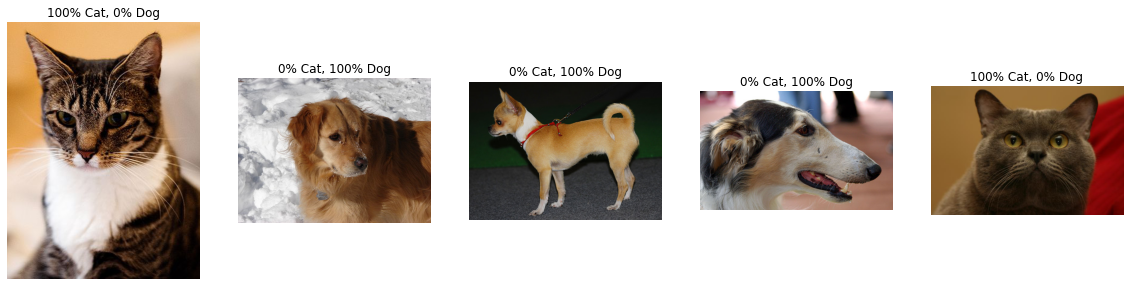

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Cat, {:.0f}% Dog".format(100*pred_probs[i,0], 100*pred_probs[i,1]))
    ax.imshow(img)

In [ ]:
# Find the total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} Total Parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} Training Parameters.')

58,406,338 Total Parameters.
262,530 Training Parameters.


# **Part 4 :** Freeze Layers of EfficientNet-B4 and Train on Oxford-III Pets.

## Import Dependencies

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
print(tf.VERSION)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

1.15.2


In [ ]:
batch_size = 32
width = 224
height = 224
epochs = 10
NUM_TRAIN = 6302 
NUM_TEST = 1115
dropout_rate = 0.2
input_shape = (height, width, 3)


train_dir = 'Pet_Images/Train'
test_dir = 'Pet_Images/Validation'

## Create Data Generators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 6302 images belonging to 2 classes.
Found 1115 images belonging to 2 classes.


In [ ]:
# Install Keras Efficient-Net
!pip install -U --pre efficientnet

## Create the Network

In [ ]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from keras import Model
import efficientnet.keras as efn

base_model = efn.EfficientNetB4(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

ERROR! Session/line number was not unique in database. History logging moved to new session 67


## Train the Model

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
196/196 [==============================] - 850s 4s/step - loss: 0.2413 - acc: 0.9078 - val_loss: 0.0517 - val_acc: 0.9908
Epoch 2/10

196/196 [==============================] - 132s 673ms/step - loss: 0.1010 - acc: 0.9609 - val_loss: 0.0290 - val_acc: 0.9926
Epoch 3/10
196/196 [==============================] - 131s 670ms/step - loss: 0.0875 - acc: 0.9670 - val_loss: 0.0256 - val_acc: 0.9898
Epoch 4/10
196/196 [==============================] - 131s 670ms/step - loss: 0.0629 - acc: 0.9775 - val_loss: 0.0166 - val_acc: 0.9954
Epoch 5/10
196/196 [==============================] - 132s 673ms/step - loss: 0.0576 - acc: 0.9794 - val_loss: 0.0162 - val_acc: 0.9954
Epoch 6/10
196/196 [==============================] - 131s 669ms/step - loss: 0.0512 - acc: 0.9818 - val_loss: 0.0120 - val_acc: 0.9982
Epoch 7/10
196/196 [==============================] - 132s 676ms/step - loss: 0.0474 - acc

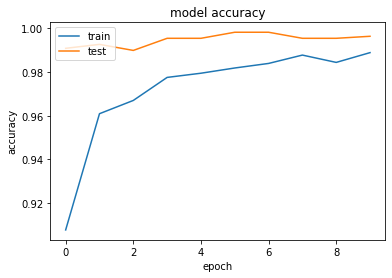

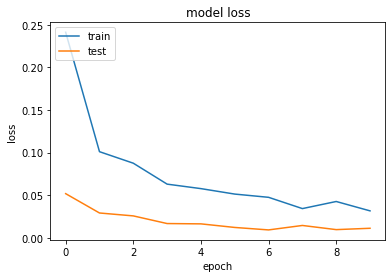

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save the model
model.save('/content/Dataset/Part6.h5')

## Make Prediction on Sample Test Images 

In [ ]:
validation_img_paths = ["/content/Dataset/Validation/360px-American_Shorthair.jpg",
                        "/content/Dataset/Validation/640px-CPRileySnow.jpg",
                        "/content/Dataset/Validation/640px-Chihuahua_01_K.jpg",
                        "/content/Dataset/Validation/640px-Kufa_charta_-_borzoja.jpg",
                        "/content/Dataset/Validation/LakiJustbluein.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    return print(animal,'',result)

In [ ]:
print(predict_image('/content/Dataset/Validation/360px-American_Shorthair.jpg'))

('cat', 0.99991155)


cat  0.99991155
dog  0.9997997319587739
dog  0.999839860262
dog  0.9983689994551241
cat  0.999946


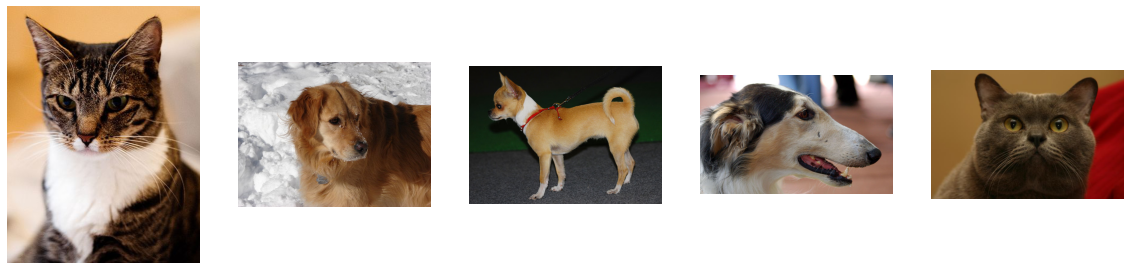

In [ ]:
Outcome = []
for x in validation_img_paths:
  Outcome.append(predict_image(x))
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title(Outcome[1])
    ax.imshow(img)